In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## To reuse this script
Change:
- the data files for the efficiency and time data, as well as the background data if you have a time series
- n to the number of vials
- c to the radiation concentration of the original solution
- c_time to the time and date when the above concentration was measured

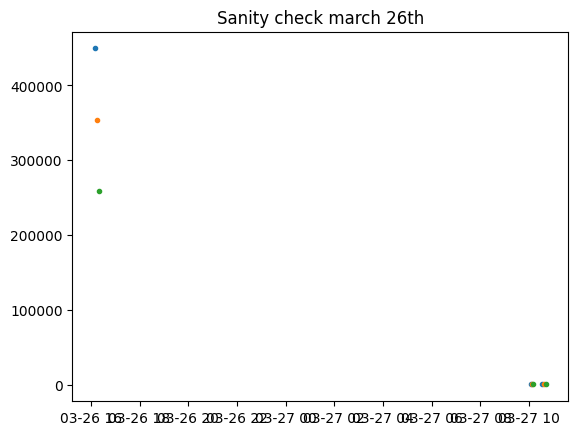

In [2]:
data = np.genfromtxt("efficiency_set3.csv", delimiter=",", skip_header=1, usecols=[3, 6, 8], encoding="utf8")
# shape: mass of sample, deadtime factor, CPM
time = np.genfromtxt("efficiency_set3.csv", delimiter=",", skip_header=1, usecols=[4], encoding="utf8", dtype='datetime64')
n = 5 # number of vials

# subtract the background
bg = 41
data[:,2] = data[:,2] - bg

plt.figure()
plt.title("Sanity check march 26th")
plt.plot(time[0::n], data[0::n, 2], ".") # the column 2 is unnormalized CPM
plt.plot(time[1::n], data[1::n, 2], ".")
plt.plot(time[2::n], data[2::n, 2], ".")
plt.show()

[2.97515207e-05 4.71126676e-01]
[[ 8.04546529e-08 -7.21124418e-07]
 [-7.21124418e-07  2.23227480e-05]]


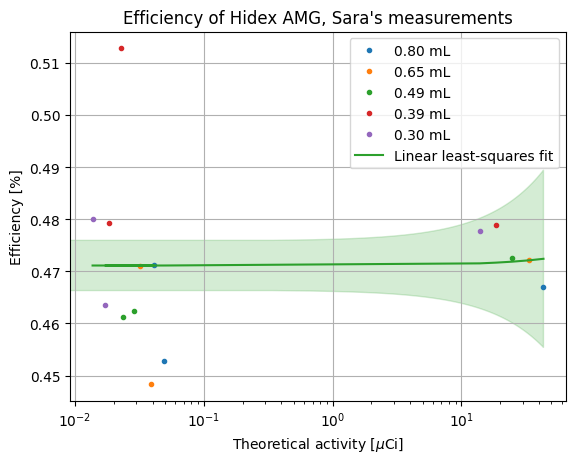

In [7]:
time_in_seconds = time.astype('datetime64[s]').astype('int')

# calculate the concentrations in the samples in CPM/ml (assuming 1g/ml)
conc = data[:,2]/data[:,0]

c_1 = 33.2076 * 0.1 * 1/37 #kBq/cc * cc/ml * mCi/kBq
c_2 = 29.9369 * 0.1 * 1/37

c = c_1 # mCi/ml, original concentration of the solution
c_time = np.datetime64('2024-03-26T14:50:15') # original time of measurement for the above concentration
c_time_in_seconds = c_time.astype('datetime64[s]').astype('int')

time_in_seconds = time_in_seconds - c_time_in_seconds # start the timer at the time of normalization

def decay(A0, t, h=109.7*60):
    # input t must be in seconds
    return A0*2**(-t/h)

# this is the theoretical concentration of radiation for each measurement in mCi/ml
ref = decay(c, time_in_seconds)


# calculate the efficiency
efficiency = conc/ref # in CPM/mCi
efficiency = efficiency * 1000 / (3.7e10 * 60) *100 # transform the cpm such that we get mCi/mCi

ref_activity = ref*data[:,0]*1000 # theoretical activity in tubes in uCi

plt.figure()
plt.title("Efficiency of Hidex AMG, Sara's measurements")
plt.ylabel("Efficiency [%]")
plt.xlabel(r"Theoretical activity [$\mu$Ci]")
plt.plot(ref_activity[0::n], efficiency[0::n], "C0.", label="0.80 mL")
plt.plot(ref_activity[1::n], efficiency[1::n], "C1.", label="0.65 mL")
plt.plot(ref_activity[2::n], efficiency[2::n], "C2.", label="0.49 mL")
plt.plot(ref_activity[3::n], efficiency[3::n], "C3.", label="0.39 mL")
plt.plot(ref_activity[4::n], efficiency[4::n], "C4.", label="0.30 mL")

#plt.xlim(0, 0.001)

plt.xscale('log')
plt.grid()

x = ref_activity
y = efficiency
b, cov = np.polyfit(x, y, 1, cov = True)
print(b)
print(cov)
plt.plot(x, x*b[0] + b[1], color='C2', label="Linear least-squares fit")
perr = np.sqrt(np.diag(cov))

x = np.linspace(0, max(x), 126)
y_plus = (b[0]+perr[0])*x + b[1]+perr[1]
y_minus = (b[0]-perr[0])*x + b[1]-perr[1]
plt.fill_between(x, y_minus, y_plus, alpha=0.2, color='C2')

plt.legend()